# **Image classification - ML**

# **Initialization**

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, recall_score, classification_report
import seaborn as sns
from sklearn import preprocessing

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Read data from csv files**

In [5]:
X = pd.read_csv("./public/train_features.csv", header=None)
y = pd.read_csv("./public/train_labels.csv", header=None)

**Split dataset into training and testing sets** 

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size=0.2)

# **Model candidates selection**

**Initial candidate models training**

In [130]:
logreg_base = LogisticRegression(
    random_state = 42,
    max_iter=1500 #To prevent iterations limit reached warning
)

xgb_base = xgb.XGBClassifier(
    objective='multi:softmax', 
    random_state = 42
)

rf_base = RandomForestClassifier(
    random_state = 42
)


logreg_base.fit(X_train, y_train.values.ravel())

xgb_base.fit(X_train, y_train.values.ravel())

rf_base.fit(X_train, y_train.values.ravel())

RandomForestClassifier(random_state=42)

**Get predictions for each model**

In [131]:
logreg_base_pred = logreg_base.predict(X_test)
xgb_base_pred = xgb_base.predict(X_test)
rf_base_pred = rf_base.predict(X_test)

**Evaluate models**

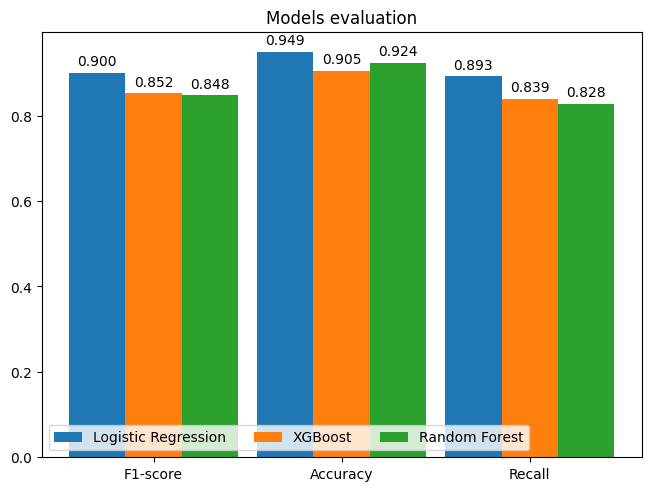

In [132]:
logreg_f1 = f1_score(y_test, logreg_base_pred, average='macro')
logreg_acc = accuracy_score(y_test, logreg_base_pred)
logreg_rec = recall_score(y_test, logreg_base_pred, average='macro')

xgb_f1 = f1_score(y_test, xgb_base_pred, average='macro')
xgb_acc = accuracy_score(y_test, xgb_base_pred)
xgb_rec = recall_score(y_test, xgb_base_pred, average='macro')

rf_f1 = f1_score(y_test, rf_base_pred, average='macro')
rf_acc = accuracy_score(y_test, rf_base_pred)
rf_rec = recall_score(y_test, rf_base_pred, average='macro')

metrics = ['F1-score', 'Accuracy', 'Recall']

models = {
    'Logistic Regression': (logreg_f1, logreg_acc, logreg_rec),
    'XGBoost': (xgb_f1, xgb_acc, xgb_rec),
    'Random Forest': (rf_f1, rf_acc, rf_rec)
}

fig, ax = plt.subplots(layout='constrained')

x = np.arange(len(metrics))
width = 0.3 
multiplier = 0
for attribute, measurement in models.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, fmt='%.3f', padding=3)
    multiplier += 1

ax.set_title('Models evaluation')
ax.set_xticks(x + width, metrics)
ax.legend(loc='lower left', ncols=3)
plt.show()

**Analysis**

Considering these plots, we can see that Logistic Regression has the best performance. Thus, we will move forward with this model.

# **Feature Design**


## Sparsity check

In [64]:
#Null verification
n_null = X.isnull().sum().sum()

print(f'There are {n_null} null values in the dataset')

There are 0 null values in the dataset


## Imbalance

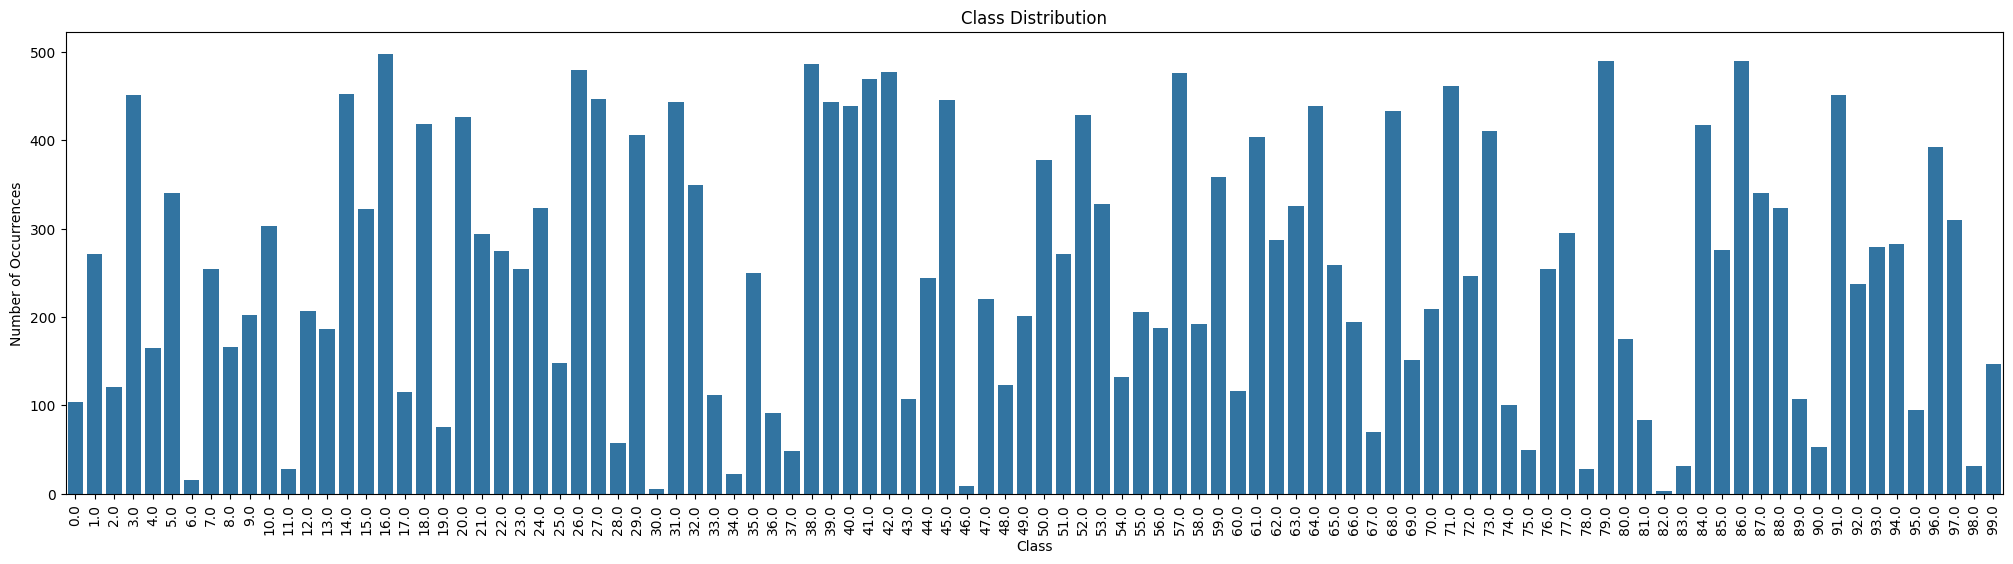

In [65]:
class_counts = y[0].value_counts()

# Create a bar plot
plt.figure(figsize=(25, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=90)
plt.show()


There is clearly an imbalance with the dataset! The solution is to add class_weight='balanced' parameter to the models. Also, we can split the dataset with stratification. Basically, this ensures that each set contains around the same perfentage of samples of each target class as the complete set.

**Split dataset**

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size=0.2, stratify=y)

In [67]:
logreg_init = LogisticRegression(
    random_state = 42,
    class_weight='balanced',
    max_iter=1000
)

logreg_init.fit(X_train, y_train.values.ravel())


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

**Print metrics function**

In [86]:
def print_metrics(y_true, y_pred):
    report = classification_report(y_true, y_pred, digits=3, zero_division=False)
    lines = [report.splitlines()[0]]
    lines.extend(report.splitlines()[-4:])

    print('\n'.join(lines) +'\n')

**Establish baseline evaluation**

In [87]:
y_test_pred = logreg_init.predict(X_test)

print_metrics(y_test, y_test_pred)

              precision    recall  f1-score   support

    accuracy                          0.949      5103
   macro avg      0.920     0.913     0.914      5103
weighted avg      0.949     0.949     0.948      5103



## Scaling

Let's try to scale the features with MinMax Scaler

In [110]:
X_train_scaled = preprocessing.MinMaxScaler().fit_transform(X_train)


[0.12144746 0.04598771 0.10817934 ... 0.08835469 0.0885807  0.07646728]
[0.08843007 0.06574313 0.11084691 ... 0.11229077 0.11188047 0.10503669]


In [108]:
logreg_scaled = LogisticRegression(
    random_state = 42,
    class_weight='balanced',
    max_iter=1000
)
logreg_scaled.fit(X_train_scaled, y_train.values.ravel())


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [109]:
y_test_pred_scaled = logreg_scaled.predict(X_test)
print_metrics(y_test, y_test_pred_scaled)


              precision    recall  f1-score   support

    accuracy                          0.916      5103
   macro avg      0.871     0.901     0.878      5103
weighted avg      0.927     0.916     0.918      5103



Scaling is not needed since performance was immensily reduced.

## SMOTE - Oversampling

Now, let's try to use SMOTE to improve dataset balance. Oversampling is done in 2 steps. The reason is that 2 classes (30 and 86) only have 2-3 examples. We will oversample them in the first round so that we minimize noise when we oversample them on the second round.



In [93]:
from imblearn.over_sampling import SMOTE

dict = { 82:10, 30:10}

sm_1 = SMOTE(sampling_strategy=dict,random_state=42,k_neighbors=1)

X_train_sm_partial, y_train_sm_partial = sm_1.fit_resample(X_train, y_train)



In [94]:
from imblearn.over_sampling import SMOTE

dict = {
6:100,
11:100,
19:100,
28:100,
30:100,
34:100,
37:100,
46:100,
67:100,
75:100,
78:100,
82:100,
83:100,
90:100,
98:100
}

sm_2 = SMOTE(sampling_strategy=dict,random_state=42,k_neighbors=5)

X_train_sm, y_train_sm = sm_2.fit_resample(X_train_sm_partial, y_train_sm_partial)



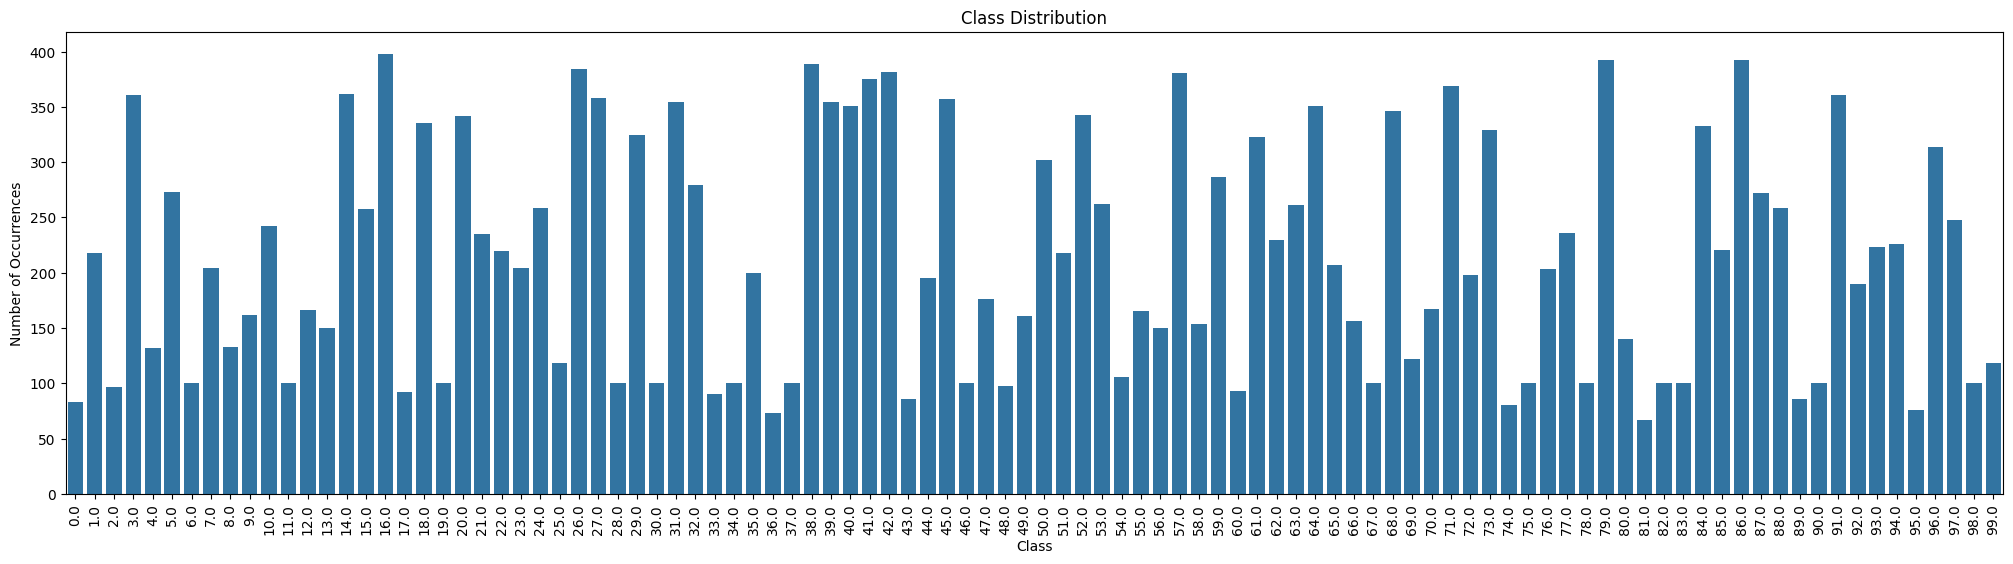

Previous train data: (20412, 1024)
New train data: (21488, 1024)


In [95]:
class_counts = y_train_sm[0].value_counts()

# Create a bar plot
plt.figure(figsize=(25, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=90)
plt.show()

print('Previous train data:', X_train.shape)
print('New train data:', X_train_sm.shape)


After oversampling, we can see that each class has more than 60 examples. Now, we will try to see if the model can have a better performance.

In [97]:
logreg_sm = LogisticRegression(
    random_state = 42,
    class_weight='balanced',
    max_iter=1500,
)
logreg_sm.fit(X_train_sm, y_train_sm.values.ravel())

LogisticRegression(class_weight='balanced', max_iter=1500, random_state=42)

In [98]:
y_test_pred_sm = logreg_sm.predict(X_test)

print_metrics(y_test, y_test_pred_sm)


              precision    recall  f1-score   support

    accuracy                          0.949      5103
   macro avg      0.923     0.913     0.916      5103
weighted avg      0.950     0.949     0.949      5103



We can see a small improvement by oversampling the dataset! Now, let's try feature selection...

## Feature Selection

In this step, we are trying to find the best number k of features to select

In [115]:
from sklearn.feature_selection import SelectKBest, chi2

n_features = [600, 700, 800, 900, 1024]

X_train_sm_scaled = preprocessing.MinMaxScaler().fit_transform(X_train_sm)

for k in n_features:
    selector = SelectKBest(chi2, k=k)
    X_train_selected = selector.fit_transform(X_train_sm_scaled, y_train_sm.values.ravel())
    X_test_selected = selector.transform(X_test)
    print(f"With {k} most important features...")
    logreg_sm.fit(X_train_selected, y_train_sm.values.ravel())
    print_metrics(y_test, logreg_sm.predict(X_test_selected))

With 600 most important features...
              precision    recall  f1-score   support

    accuracy                          0.908      5103
   macro avg      0.861     0.889     0.866      5103
weighted avg      0.919     0.908     0.909      5103

With 700 most important features...
              precision    recall  f1-score   support

    accuracy                          0.910      5103
   macro avg      0.864     0.894     0.870      5103
weighted avg      0.921     0.910     0.912      5103

With 800 most important features...
              precision    recall  f1-score   support

    accuracy                          0.912      5103
   macro avg      0.869     0.896     0.875      5103
weighted avg      0.922     0.912     0.914      5103

With 900 most important features...
              precision    recall  f1-score   support

    accuracy                          0.915      5103
   macro avg      0.871     0.897     0.876      5103
weighted avg      0.924     0.915     0

As the results suggest, we will not proceed with feature selection. The model with all the 1024 features performs the best. Instead, we will use L2 regularization for a partial feature selection.

# **Cross validation - Hyperparameter tuning**

In [138]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold

def tuning(learner, params, X_train, y_train, X_test, y_test):
    
    # Initialize Cross Validation
    stratified_cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)

    scorer = make_scorer(f1_score, average='micro')

    grid = GridSearchCV(learner, params, scoring=scorer, cv=stratified_cv, n_jobs=-1)

    # Perform Cross validation
    grid_fit = grid.fit(X_train, y_train)

    #Get best model
    best_clf = grid_fit.best_estimator_

    # Best predictions
    best_predictions = best_clf.predict(X_test)

    #Output results
    print('With parameters:', grid.best_params_)
    print_metrics(y_test, best_predictions)

    return best_clf


In [139]:
parameters = {
   'C': [0.1, 1, 2, 3],
}
logreg_tuned = tuning(logreg_sm, parameters, X_train_sm, y_train_sm.values.ravel(), X_test, y_test.values.ravel())

17791.90s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
17792.00s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
17792.10s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
17792.17s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
17792.27s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Not

With parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
              precision    recall  f1-score   support

    accuracy                          0.949      5103
   macro avg      0.932     0.909     0.916      5103
weighted avg      0.950     0.949     0.948      5103



After performing cross-validation, we can see that the optimal L2 regularization penalty C is 2.

# **Finalization**

**Train optimized model**

In [119]:
logreg_tuned = LogisticRegression(
    random_state = 42,
    class_weight='balanced',
    max_iter=1500,
    C=2
)
logreg_tuned.fit(X_train_sm, y_train_sm.values.ravel())


LogisticRegression(C=2, class_weight='balanced', max_iter=1500, random_state=42)

**Initial vs tuned model comparison**

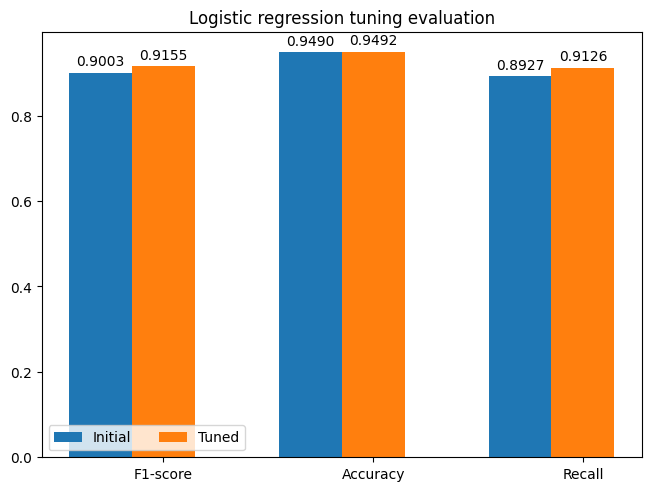

In [134]:
y_test_pred_tuned = logreg_tuned.predict(X_test)

tuned_f1 = f1_score(y_test, y_test_pred_tuned, average='macro')
tuned_acc = accuracy_score(y_test, y_test_pred_tuned)
tuned_rec = recall_score(y_test, y_test_pred_tuned, average='macro')

metrics = ['F1-score', 'Accuracy', 'Recall']

models = {
    'Initial': (logreg_f1, logreg_acc, logreg_rec),
    'Tuned': (tuned_f1, tuned_acc, tuned_rec),
}

fig, ax = plt.subplots(layout='constrained')

x = np.arange(len(metrics))
width = 0.3 
multiplier = 0
for attribute, measurement in models.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, fmt='%.4f', padding=3)
    multiplier += 1

ax.set_title('Logistic regression tuning evaluation')
ax.set_xticks(x + width, metrics)
ax.legend(loc='lower left', ncols=3)
plt.show()


In [25]:
X_test_final = pd.read_csv("./public/test_features.csv", header=None)
y_pred_final = pd.DataFrame(logreg_tuned.predict(X_test_final), columns=['TARGET'])

In [26]:
y_pred_final.index.name = 'ID'
y_pred_final.head()

,TARGET
ID,
0,27.0
1,50.0
2,63.0
3,83.0
4,70.0


In [27]:
y_pred_final.to_csv('./submission.csv')